In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn import Sequential, Linear
from torch.utils.data import TensorDataset, DataLoader
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    train_model_bnn,
    partial_train_model_bnn,
)
from bb_opt.src.utils import get_path
from gpu_utils.utils import gpu_init

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 0


In [3]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [4]:
project = "dna_binding"
dataset = "crx_ref_r1"

root = "/cluster/nhunt/github/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))

top_k_percent = 1

In [5]:
n_hidden = 100
non_linearity = 'ReLU'
n_inputs = inputs.shape[1]

In [6]:
class NN(torch.nn.Module):
    def __init__(self, n_inputs: int, n_hidden: int, min_variance: float=1e-5):
        super().__init__()
        self.hidden = Linear(n_inputs, n_hidden)
        self.output = Linear(n_hidden, 2)
        self.non_linearity = torch.nn.ReLU()
        self.softplus = torch.nn.Softplus()
        self.min_variance = min_variance

    def forward(self, x):
        hidden = self.non_linearity(self.hidden(x))
        output = self.output(hidden)
        mean = output[:, 0]
        variance = self.softplus(output[:, 1]) + self.min_variance
        return mean, variance


class NNEnsemble(torch.nn.Module):
    """
    Note that if training your model takes a lot of GPU resources, it would be better to train
    the individual models on separate GPUs in parallel and then save them and load the weights
    into an ensemble afterwards for evaluation.
    """
    def __init__(self, n_models: int, n_inputs: int, n_hidden: int, min_variance: float=1e-5, adversarial_epsilon: Optional=None):
        super().__init__()
        self.n_models = n_models
        self.models = torch.nn.ModuleList([NN(n_inputs, n_hidden, min_variance) for _ in range(n_models)])
        self.adversarial_epsilon = adversarial_epsilon

    def forward(self, x, y=None, optimizer=None, individual_predictions: bool=True):
        if y is not None and self.adversarial_epsilon is not None:
            x.requires_grad_()
            means, variances = self(x)
            negative_log_likelihood = compute_negative_log_likelihood(y, means, variances)
            
            grad = torch.autograd.grad(negative_log_likelihood, x, retain_graph=optimizer is not None)[0]
            x = x.detach() + self.adversarial_epsilon * torch.sign(grad)
            
            if optimizer:
                # then do a backward pass on x as well as returning the prediction
                # for x_adv to do a pass on that
                negative_log_likelihood.backward()
                optimizer.step()
                optimizer.zero_grad()

        means, variances = list(zip(*[self.models[i](x) for i in range(self.n_models)]))

        if individual_predictions:
            return torch.stack(means), torch.stack(variances)

        return combine_means_variances(means, variances)

def combine_means_variances(means: torch.Tensor, variances: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    mean = means.mean(dim=0)
    variance = (variances + means ** 2).mean(dim=0) - mean ** 2
    return mean, variance

def compute_negative_log_likelihood(labels, means, variances, return_mse: bool=False):
    mse = (labels - means) ** 2
    negative_log_likelihood = 0.5 * (torch.log(variances) + mse / variances)
    negative_log_likelihood = negative_log_likelihood.mean(dim=-1).sum()
    
    if return_mse:
        mse = mse.mean(dim=-1).sum()
        return negative_log_likelihood, mse
    return negative_log_likelihood

In [13]:
batch_size = 128
n_train = 1000

train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)

train_inputs = torch.tensor(train_inputs).float().to(device)
train_labels = torch.tensor(train_labels).float().to(device)
train_data = TensorDataset(train_inputs, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_inputs = torch.tensor(test_inputs).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

/cluster/nhunt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [176]:
n_models = 100

mins = train_inputs.min(dim=0)[0]
maxes = train_inputs.max(dim=0)[0]
adversarial_epsilon = 0.01 * (maxes - mins)
adversarial_epsilon = None

# model = NN(n_inputs, n_hidden).to(device)
model = NNEnsemble(n_models, n_inputs, n_hidden, adversarial_epsilon=adversarial_epsilon).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Ensemble Testing

In [177]:
train_nll = []
train_mse = []
test_nll = []
test_mse = []
epoch = 0

In [ ]:
for epoch in range(epoch, epoch + 6000):
    model.train()
    for batch in train_loader:
        batch_inputs, batch_labels = batch
        optimizer.zero_grad()

        means, variances = model(batch_inputs, batch_labels)

        negative_log_likelihood, mse = compute_negative_log_likelihood(batch_labels, means, variances, return_mse=True)
        negative_log_likelihood.backward()

        optimizer.step()

        train_nll.append(negative_log_likelihood.item())
        train_mse.append(mse.item())

    model.eval()
    with torch.no_grad():
        means, variances = model(test_inputs)

        negative_log_likelihood, mse = compute_negative_log_likelihood(test_labels, means, variances, return_mse=True)        
        test_nll.append(negative_log_likelihood.item())
        test_mse.append(mse.item())

    if epoch % 100 == 0:
        print(f'[E{epoch}] Train NLL = {train_nll[-1]:,.0f}. Test NLL = {test_nll[-1]:,.0f}')

[E0] Train NLL = 105,505,202,176. Test NLL = 93,042,147,328
[E100] Train NLL = 1,561,806,080. Test NLL = 1,569,690,368
[E200] Train NLL = 832,269,824. Test NLL = 790,373,056
[E300] Train NLL = 520,061,536. Test NLL = 504,217,760
[E400] Train NLL = 365,008,928. Test NLL = 349,408,704
[E500] Train NLL = 262,247,376. Test NLL = 250,783,376
[E600] Train NLL = 168,484,176. Test NLL = 182,276,096
[E700] Train NLL = 134,560,336. Test NLL = 132,344,464
[E800] Train NLL = 92,421,408. Test NLL = 94,956,784
[E900] Train NLL = 65,486,804. Test NLL = 66,644,440
[E1000] Train NLL = 43,747,044. Test NLL = 45,227,652
[E1100] Train NLL = 35,149,832. Test NLL = 29,316,904
[E1200] Train NLL = 16,193,867. Test NLL = 17,978,356
[E1300] Train NLL = 11,329,847. Test NLL = 10,482,231
[E1400] Train NLL = 4,173,482. Test NLL = 6,086,251
[E1500] Train NLL = 3,683,610. Test NLL = 3,905,650
[E1600] Train NLL = 1,730,649. Test NLL = 2,970,903
[E1700] Train NLL = 1,729,497. Test NLL = 2,533,377
[E1800] Train NLL = 2

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(np.linspace(0, len(test_nll), len(train_nll)), train_nll, label="Train")
plt.plot(test_nll, label="Test")
plt.yscale("log")
plt.legend()
plt.title("NLL")

plt.subplot(122)
plt.plot(np.linspace(0, len(test_mse), len(train_mse)), train_mse, label="Train")
plt.plot(test_mse, label="Test")
plt.yscale("log")
plt.legend()
plt.title("MSE");

In [ ]:
title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

with torch.no_grad():
    means, variances = model(train_inputs)
mean, variance = combine_means_variances(means, variances)
jointplot(mean, train_labels, train_title)

with torch.no_grad():
    means, variances = model(test_inputs)
mean, variance = combine_means_variances(means, variances)
jointplot(mean, test_labels, test_title)

In [ ]:
%%notify
""

$M = 1$ (no AT, 50% train)

89 87
91 88
92 89
93 90 (2600 @ 128)

$M = 5$ (AT, 1K train)
46 42 (1600 @ 128)
67 62 (2600)
69 62 (3600)
82 68 (4600)
92 71 (6600)
99 71 (12600)

$M = 5$ (no AT, 1K train)
91 71 (6000 @ 128)

$M = 100$ (no AT, 1K train)
 (6000 @ 128)

In [56]:
train_labels.max()

tensor(258252.7969, device='cuda:0')

In [50]:
with torch.no_grad():
    means, variances = model(test_inputs)

In [68]:
sorted_idx = means.sort(dim=1, descending=True)[1]

In [75]:
i = 0
[f"{test_labels[sorted_idx[i][:10]].max().item():,.0f}" for i in range(len(sorted_idx))]

['181,430', '279,365', '262,527', '190,107', '306,347']

In [86]:
len(set(q.contiguous().view(-1).tolist()))

21

In [88]:
test_labels.sort(descending=True)[0][:10]

tensor([366908.3750, 366577.5938, 343089.6562, 330452.0000, 328993.2812,
        328504.0938, 327849.2812, 323384.2188, 317339.3750, 311019.8750],
       device='cuda:0')

In [90]:
mean, variance = combine_means_variances(means, variances)

In [171]:
n_samples = 5000
i = 0

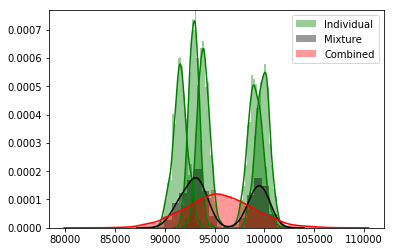

In [175]:
mixture_samples = np.random.normal(means[:, i], variances[:, i].sqrt(),
                                   ((n_samples // model.n_models, model.n_models)))
combined_samples = np.random.normal(mean[i], variance[i].sqrt(), size=n_samples)

for j in range(model.n_models):
    sns.distplot(mixture_samples[:, j], label="Individual" if j == 0 else None, color="green")

sns.distplot(mixture_samples.ravel(), label="Mixture", color="black")
sns.distplot(combined_samples, label="Combined", color="red")
plt.legend()

i += 1

In [55]:
test_labels.max()

tensor(366908.3750, device='cuda:0')

In [54]:
test_labels[means.argmax(dim=1)]

tensor([141012.4531, 138143.2188, 141012.4531, 141012.4531, 141012.4531],
       device='cuda:0')

In [51]:
means.shape

torch.Size([5, 31896])

In [387]:
with torch.no_grad():
    means, variances = model(train_inputs)

mean, variance = combine_means_variances(means, variances)
sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
cdf_probs = 0.5 * (1 + torch.erf((train_labels - mean) / (variance.sqrt() * sqrt2)))

In [388]:
eq = np.array([(cdf_probs <= cdf_prob).float().mean() for cdf_prob in cdf_probs])
eq

array([0.70409775, 0.81341195, 0.7310919 , ..., 0.7262889 , 0.5938716 ,
       0.12171692], dtype=float32)

In [389]:
from sklearn.isotonic import IsotonicRegression

In [390]:
calibration_regressor = IsotonicRegression(0, 1)

In [391]:
calibration_regressor.fit(cdf_probs, eq)

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=1, y_min=0)

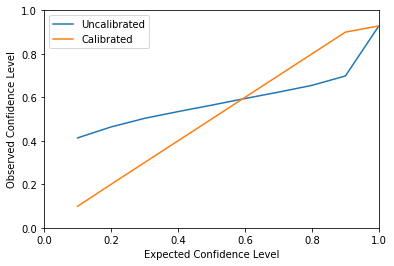

In [392]:
with torch.no_grad():
    means, variances = model(train_inputs)

mean, variance = combine_means_variances(means, variances)
sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
cdf_probs = 0.5 * (1 + torch.erf((train_labels - mean) / (variance.sqrt() * sqrt2)))

threshes = np.linspace(.1, 1, 10)
e = [(cdf_probs < thresh).float().mean().item() for thresh in threshes]
plt.plot(threshes, e, label="Uncalibrated")

cdf_probs = calibration_regressor.transform(cdf_probs)
e = [(cdf_probs < thresh).mean() for thresh in threshes]
plt.plot(threshes, e, label="Calibrated")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Expected Confidence Level")
plt.ylabel("Observed Confidence Level")
plt.legend();

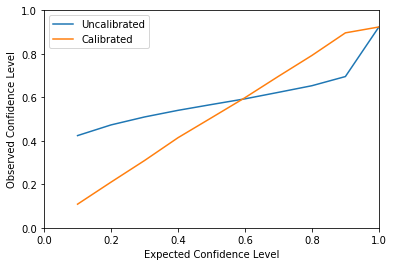

In [393]:
with torch.no_grad():
    means, variances = model(test_inputs)

mean, variance = combine_means_variances(means, variances)
sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
cdf_probs = 0.5 * (1 + torch.erf((test_labels - mean) / (variance.sqrt() * sqrt2)))

threshes = np.linspace(.1, 1, 10)
e = [(cdf_probs < thresh).float().mean().item() for thresh in threshes]
plt.plot(threshes, e, label="Uncalibrated")

cdf_probs = calibration_regressor.transform(cdf_probs)
e = [(cdf_probs < thresh).mean() for thresh in threshes]
plt.plot(threshes, e, label="Calibrated")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Expected Confidence Level")
plt.ylabel("Observed Confidence Level")
plt.legend();

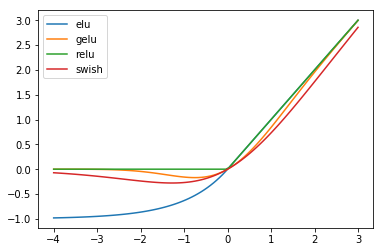

In [20]:
import pandas as pd

sigmoid = lambda x: 1 / (1 + np.exp(-x))

alpha_elu = 1
alpha_selu = 1.67326
lambda_selu = 1.0507

x = np.linspace(-4, 3, 100)
y = {
    "gelu": 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x **3))),
    "relu": np.maximum(0, x),
    "elu": np.where(x < 0, alpha_elu * (np.exp(x) - 1), x),
#     "selu": lambda_selu * np.where(x < 0, alpha_selu * (np.exp(x) - 1), x),
    "swish": x * sigmoid(x)
}

df = pd.DataFrame(y)
df.plot(x=x)